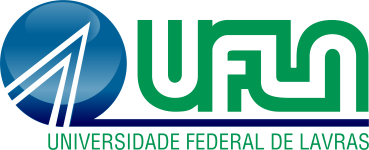

# Parallel Simulated Annealing

Trabalho Final da disciplina **Programação Paralela e Concorrente** (2023/1).


**Professora:** Marluce Rodrigues Pereira

**Alunos:**

- João Gabriel Kondarzewski Zanella - 202020091
- Henrique Curi de Miranda - 202020087
- Victor Gonçalves Lima - 202020775

O trabalho tem como objeto paralelizar o algorimo de otimização ***Simulated Annealing*** e analizar os resutados obtidos.

## Importações

In [1]:
from src.funcoes_registro import carregar_populacao, carregar_solucao_inicial, carregar_parametros_populacao
from src.funcoes_plotagem import plotar_itens

## Dispersão dos itens

In [2]:
parametros_populacao = carregar_parametros_populacao("./parametros_iniciais/")

parametros_populacao

{'numero_itens': 10000,
 'valor_minimo': 1,
 'valor_maximo': 5,
 'tipo_valor': 'int',
 'peso_minimo': 10.0,
 'peso_maximo': 1000.0,
 'tipo_peso': 'float'}

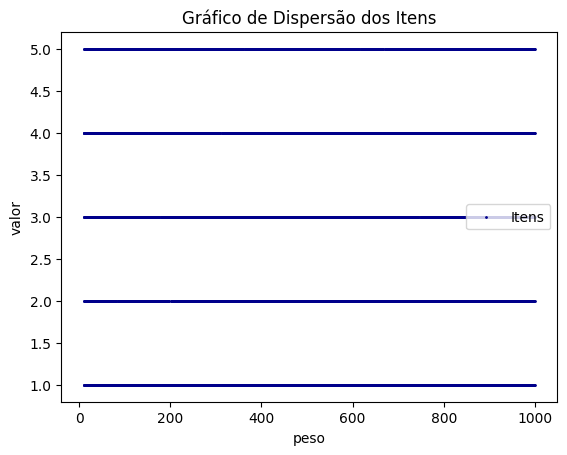

In [3]:
itens = carregar_populacao("./parametros_iniciais/")

plotar_itens(itens)

## Solução aleatória

Total de itens na mochila: 22
Valor total na mochila: 67
Peso total na mochila: 9989.963056240924


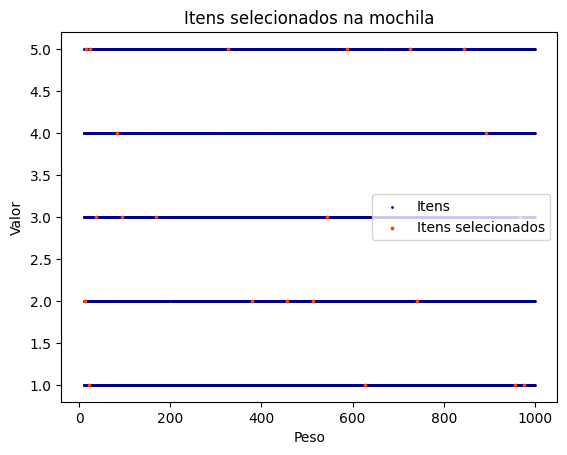

In [4]:
capacidade_das_mochilas = 10000.0 # 10 toneladas
mochila_inicial = carregar_solucao_inicial("./parametros_iniciais/", itens)
plotar_itens(itens, mochila_inicial)